<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy the filters from ex7
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib
from skimage import feature, io, color

In [3]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_data_reduced.csv'
column_names = ['path', 'index', 'label']
df_train = pd.read_csv(csv_file_path, names=column_names)
df_train = df_train.iloc[1:]
df_train = df_train.reset_index(drop=True)

In [4]:
print(df_train.shape)
df_train.head(5)

(2000, 3)


,path,index,label
0,/content/drive/MyDrive/galaxy_zoo/Train_images...,469264,Class0
1,/content/drive/MyDrive/galaxy_zoo/Train_images...,765243,Class0
2,/content/drive/MyDrive/galaxy_zoo/Train_images...,141731,Class0
3,/content/drive/MyDrive/galaxy_zoo/Train_images...,590463,Class0
4,/content/drive/MyDrive/galaxy_zoo/Train_images...,591026,Class0


In [5]:
# preprocess and pipeline

def grayscale_preprocessing(img):
  if np.max(img)>1:
    img = img.astype(np.float32)/255.0
  im_gray = np.mean(img, axis=2)
  return im_gray

def bilateral_preprocessing(img, ksize, sigmX, sigmY):
  bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
  return bilateral_filtered_image

def high_pass_preprocessing(img, ksize, sig):
  low_pass = cv2.GaussianBlur(img, ksize, 0)
  high_pass = img - low_pass
  return high_pass

def sobel_preprocessing(img, ksize):
  sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize) # Find x and y gradients
  sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
  magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
  magnitude = magnitude / np.max(magnitude) # normalize
  return magnitude

def gaussian_blur_preprocessing(img, ksize, sigma):
  blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
  return blurred_im

def canny_filter(img, high_threshold, low_threshold):
  # ensure the image is normalized to the range [0, 1]
  img = img / np.max(img)
  # scale the image to the range [0, 255] and convert to 8-bit
  img_8u = np.uint8(img * 255)
  # threshold the image and get the interesting points
  # The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
  # The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
  # By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

  im_threshold = cv2.Canny(image=img_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
  im_threshold = im_threshold / np.max(im_threshold) # normalize
  return im_threshold

def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]


def histogram_clipping(img, threshold_value):
  clipped_image = img.copy()
  # before
  # draw_histogram_gray(clipped_image)
  clipped_image[img < threshold_value/255.0] = 0
  # Normalize the clipped_image to 0-255 for proper histogram visualization
  normalized_clipped_image = cv2.normalize(clipped_image, None, alpha=0, beta=255,
                                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  # draw_histogram_gray(clipped_image)
  return normalized_clipped_image

def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
  block_norm = 'L1'  # Block normalization method
  # orientations = 9   # Number of orientation bins
  # pixels_per_cell = (8, 8)  # Size of the cell
  # cells_per_block = (3, 3)  # Size of the block

  # Compute the HOG features
  hog_features, hog_image = feature.hog(img_gray,
                                        orientations=orientations,
                                        pixels_per_cell=pixels_per_cell,
                                        cells_per_block=cells_per_block,
                                        block_norm=block_norm,
                                        visualize=True)
  return hog_features, hog_image

def preprocess_1(df):
  image_dir = df['path'] # ignore index
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_sobel = sobel_preprocessing(im_bilateral, 31)
    im_canny = canny_filter(im_blurred, 70, 0)
    im_cropped = crop_center(im_canny, 252, 252)
    im_flattened = im_cropped.flatten()
    preprocessed_list.append(im_flattened)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed

def preprocess_2(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 240, 240)
    hog_feature, hog_image = hog(im_cropped) #(63504,)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(hog_feature)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed

In [ ]:
# preprocessed_list = []
# for i, image_path in enumerate(df_train['path'][:3]):
#   im = np.array(Image.open(image_path))
#   im_gray = grayscale_preprocessing(im)
#   img_histogram_clipping = histogram_clipping(im_gray, 30)
#   im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
#   im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
#   im_cropped = crop_center(im_bilateral, 240, 240)
#   hog_feature, hog_image = hog(im_cropped) #(63504,)
#     # im_flattened = hog_feature.flatten()
#   preprocessed_list.append(hog_feature)

# df = pd.DataFrame(preprocessed_list)
# df.columns = [f'feature_{i}' for i in range(len(df.columns))]
# df
# # df_processed_combined = pd.concat([df_train.iloc[0:3], df], axis=1)
# # df_processed_combined


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_63494,feature_63495,feature_63496,feature_63497,feature_63498,feature_63499,feature_63500,feature_63501,feature_63502,feature_63503
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_preprocessed_1 = preprocess_1(df_train)
df_preprocessed_1.columns = [f'feature_{i}' for i in range(len(df_preprocessed_1.columns))]
df_preprocessed_2 = preprocess_2(df_train)
df_preprocessed_2.columns = [f'feature_{i}' for i in range(len(df_preprocessed_2.columns))]
print(df_preprocessed_1.shape, df_preprocessed_2.shape)

In [ ]:
print(df_preprocessed_1.shape, df_preprocessed_2.shape)

(2000, 63504) (2000, 63504)


In [ ]:
# feature in the df_preprocessed_1 is either 0 or 1
# feature in the df_preprocessed_2 is between 0 to 1
# need no normalization

In [ ]:
# feature in the df_preprocessed_1 is either 0 or 1
# feature in the df_preprocessed_2 is between 0 to 1
# need no normalization before PCA

df_preprocessed_2.iloc[:1].T

,0
feature_0,0.0
feature_1,0.0
feature_2,0.0
feature_3,0.0
feature_4,0.0
...,...
feature_63499,0.0
feature_63500,0.0
feature_63501,0.0
feature_63502,0.0


In [ ]:
from sklearn.decomposition import PCA

def pick_top_feature_pca(feature_matrix, top_components):
#pick up top 100 features by PCA
  pca = PCA(n_components=500)
  pca.fit(feature_matrix)
  principal_components = pca.transform(feature_matrix)
  top_components_matrix = principal_components[:, :top_components]

  plt.figure(figsize=(8, 4))
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('Number of PCA components')
  plt.ylabel('Cumulative explained variance')
  plt.title('Explained Variance vs Number of PCA Components')
  plt.grid(True)
  plt.show()
  # Extract the top n components
  return top_components_matrix

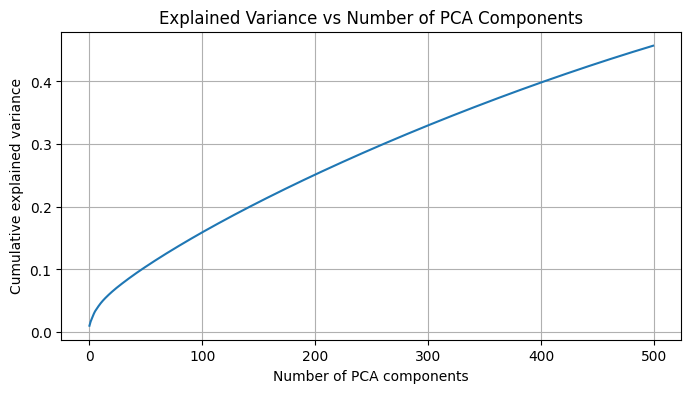

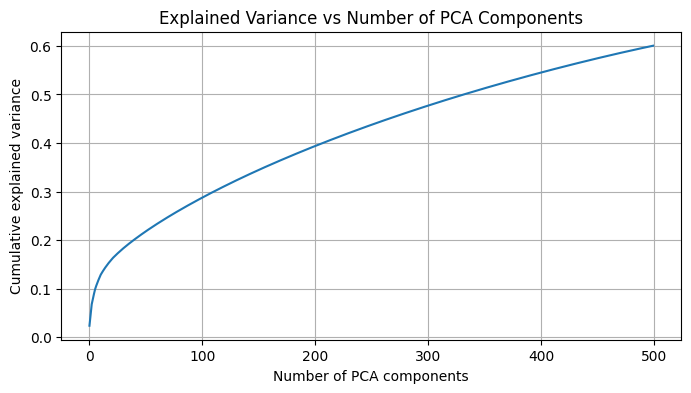

In [ ]:
#only get top 200 features for each pipeline

df_top_100_feature_pca_1 = pd.DataFrame(pick_top_feature_pca(df_preprocessed_1.values, 200))
df_top_100_feature_pca_2 = pd.DataFrame(pick_top_feature_pca(df_preprocessed_2.values, 200))

In [ ]:
# feature normarlization since we only pick up top 200. z score normalization

from sklearn.preprocessing import StandardScaler

def feature_normalization(df_feature):
  scaler = StandardScaler()
  normalized_features = scaler.fit_transform(df_feature.values)
  df_normalized = pd.DataFrame(normalized_features, columns=df_feature.columns)
  return df_normalized

In [ ]:
df_top_100_feature_pca_1_normalized = feature_normalization(df_top_100_feature_pca_1)
df_top_100_feature_pca_2_normalized = feature_normalization(df_top_100_feature_pca_2)

In [ ]:
df_top_100_feature_pca_1_normalized.head(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.683016,-0.199112,0.433763,-0.604916,1.650760,0.195035,0.422669,0.330931,-0.744592,-0.187668,...,1.918000,1.127443,-1.190626,0.207241,-1.849393,-1.489315,-0.345781,0.180477,0.558292,0.553137
1,0.428554,0.007555,0.096317,0.492547,-1.008266,-0.885735,1.283975,-0.058103,1.346533,2.226872,...,0.031838,2.947122,0.499421,-3.109416,2.013632,-1.484715,2.511756,-1.269522,1.846336,1.961294
2,0.948607,-0.233731,1.150844,-2.470553,0.992961,-0.471629,0.186722,-1.700747,-0.186734,1.469688,...,-0.741273,-0.231731,1.306533,1.259910,0.503218,-1.756641,-1.787921,0.194940,0.991923,-0.135000
3,2.471789,-0.106321,1.377757,-2.424989,-0.943565,-0.660117,1.153095,-1.056209,1.272605,-1.182909,...,-4.652786,1.775402,0.275730,0.499222,-1.215465,-0.755859,-1.727788,-2.418978,-2.099273,-0.281670
4,-0.048414,-0.350414,0.388104,0.109586,-0.470674,1.224412,-0.424866,0.871461,1.257238,1.812530,...,1.158000,0.221191,0.832498,-0.009632,-0.085609,-0.962725,-1.462415,1.834604,0.416675,0.688544


In [ ]:
df_train_reduced_preprocessed_pca_1_2 = pd.concat([df_train, df_top_100_feature_pca_1_normalized, df_top_100_feature_pca_2_normalized], axis=1)
print(df_top_100_feature_pca_1.shape, df_top_100_feature_pca_2.shape, df_train_reduced_preprocessed_pca_1_2.shape)

(2000, 200) (2000, 200) (2000, 403)


In [ ]:
df_top_100_feature_pca_1_normalized.to_csv('/content/drive/MyDrive/galaxy_zoo/df_train_reduced_processed_pca_1', index=False)
df_top_100_feature_pca_2_normalized.to_csv('/content/drive/MyDrive/galaxy_zoo/df_train_reduced_processed_pca_2', index=False)
df_train_reduced_preprocessed_pca_1_2.to_csv('/content/drive/MyDrive/galaxy_zoo/df_train_reduced_processed_pca_1_2', index=False)

In [6]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/df_train_reduced_processed_pca_2'
df_pipeline_2 = pd.read_csv(csv_file_path)
df_pipeline_2.head(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.532794,0.992728,1.996416,-1.135522,-1.245478,1.519503,-0.578141,-0.414509,-0.419156,1.548022,...,-0.311918,-1.260388,-1.608719,0.116867,-0.635634,0.148331,-0.161887,1.859439,1.822859,0.501298
1,0.674061,-1.338483,-0.685376,-1.111332,0.159913,-1.249315,-0.011606,-0.801587,-0.395866,0.889733,...,0.616897,-0.137387,-0.425665,1.031272,0.307947,-0.006651,1.304492,-0.429581,2.104466,-1.494759
2,1.423955,1.971829,0.892988,-1.654168,-0.053250,-1.631495,2.005810,0.304517,0.581106,-1.410626,...,0.295346,0.473024,1.820238,-1.286893,0.636804,0.428659,-0.102759,0.419371,-0.090699,0.026570
3,1.241426,2.360012,-0.147344,0.307981,0.502032,-2.600488,0.126311,1.143269,-1.222063,-2.068815,...,0.846482,0.486456,-0.854918,0.116619,-0.167782,1.793057,-0.302606,-1.302269,-0.569480,-0.789079
4,0.987700,1.119329,-1.547274,1.649971,0.410670,0.062172,-0.156859,-0.591523,-0.043572,0.126961,...,-1.032969,0.243089,0.162941,-0.592694,0.988855,0.725309,0.739634,-0.034890,0.090372,0.618199


In [10]:
df_train_pipeline_2 = pd.concat([df_train, df_pipeline_2], axis=1)
df_train_pipeline_2['label'] = df_train_pipeline_2['label'].str.replace("Class", "").astype(int)
df_train_pipeline_2.head(5)

,path,index,label,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,/content/drive/MyDrive/galaxy_zoo/Train_images...,469264,0,0.532794,0.992728,1.996416,-1.135522,-1.245478,1.519503,-0.578141,...,-0.311918,-1.260388,-1.608719,0.116867,-0.635634,0.148331,-0.161887,1.859439,1.822859,0.501298
1,/content/drive/MyDrive/galaxy_zoo/Train_images...,765243,0,0.674061,-1.338483,-0.685376,-1.111332,0.159913,-1.249315,-0.011606,...,0.616897,-0.137387,-0.425665,1.031272,0.307947,-0.006651,1.304492,-0.429581,2.104466,-1.494759
2,/content/drive/MyDrive/galaxy_zoo/Train_images...,141731,0,1.423955,1.971829,0.892988,-1.654168,-0.053250,-1.631495,2.005810,...,0.295346,0.473024,1.820238,-1.286893,0.636804,0.428659,-0.102759,0.419371,-0.090699,0.026570
3,/content/drive/MyDrive/galaxy_zoo/Train_images...,590463,0,1.241426,2.360012,-0.147344,0.307981,0.502032,-2.600488,0.126311,...,0.846482,0.486456,-0.854918,0.116619,-0.167782,1.793057,-0.302606,-1.302269,-0.569480,-0.789079
4,/content/drive/MyDrive/galaxy_zoo/Train_images...,591026,0,0.987700,1.119329,-1.547274,1.649971,0.410670,0.062172,-0.156859,...,-1.032969,0.243089,0.162941,-0.592694,0.988855,0.725309,0.739634,-0.034890,0.090372,0.618199


Classifier LDA reduction (4 features) and logistic regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix

X = df_train_pipeline_2.drop(['path', 'index', 'label'], axis=1)  # features
y = df_train_pipeline_2['label'] # label

# split the data here (need to circle back and use the actual testing data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LDA to reduce the dimension to number of class - 1
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)

#logistic regression as the classifer in the space of LDA space
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)

# Logistic Regression with L1 regularization
# [0.001, 0.01, 0.1, 1]
classifier_l1 = LogisticRegression(penalty='l1', C=1 , solver='liblinear')
classifier_l1.fit(X_train_lda, y_train)

# Logistic Regression with L2 regularization
# C [0.1, 1, 10, 100]
classifier_l2 = LogisticRegression(penalty='l2', C=100)
classifier_l2.fit(X_train_lda, y_train)

# transform the test data to the LDA feature space and make predictions
X_test_lda = lda.transform(X_test)
y_pred = classifier.predict(X_test_lda)

# evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print("validation accuracy:", accuracy)

# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Assess Overfitting
# To assess overfitting, you can compare the performance on the training set and test set.
# If the model performs significantly better on the training set compared to the test set, it may be overfitting.
train_accuracy = accuracy_score(y_train, classifier.predict(X_train_lda))
print("Training Accuracy:", train_accuracy)
train_accuracy_l1 = accuracy_score(y_train, classifier_l1.predict(X_train_lda))
train_accuracy_l2 = accuracy_score(y_train, classifier_l2.predict(X_train_lda))

print("Training Accuracy with L1 Regularization:", train_accuracy_l1)
print("Training Accuracy with L2 Regularization:", train_accuracy_l2)

validation accuracy: 0.6525
Confusion Matrix:
[[56  2  0 22  3]
 [ 1 46 14  0 16]
 [ 0 19 58  2  3]
 [17  2  0 45  4]
 [ 6 23  4  1 56]]
Training Accuracy: 0.80375
Training Accuracy with L1 Regularization: 0.793125
Training Accuracy with L2 Regularization: 0.8025


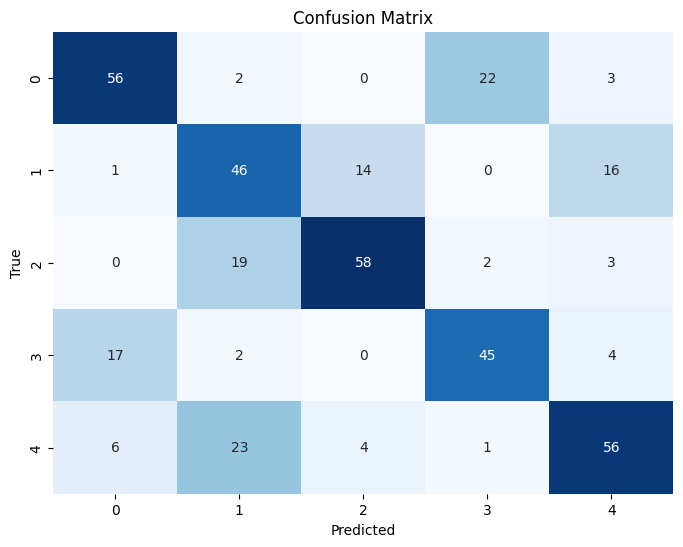

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()